# Image Partition using Diffusion maps 2

Using the Nyström method discribed in the paper: [Spectral grouping using the Nystrom method](https://escholarship.org/uc/item/29z29233).

How the eigenvalues and eigenvectors are approximated is slightly different than [IP_DM_Nystrom_v1.ipynb](). 

For the $n*n$ matrix $Q = \left[\begin{matrix}
A & B^T  \\
B & C \\
\end{matrix}\right] $, Nystrom extension gives
$$ Q \approx \left[\begin{matrix} A \\B \end{matrix}\right] A^{-1} \left[\begin{matrix} A & B^T \end{matrix}\right].$$

In the paper, scholar proved that by diagonalizing $S:= A+A^{-1/2} B^T B A^{-1/2}$ as $S=ULU^T$, the approximate eigenvectors of diffusion matrix are given by
$ D\left[\begin{matrix} A \\B \end{matrix}\right]A^{-1/2}UL^{-1/2}$, and the eigenvalues of diffusion matrix are equal to the eigenvalues of $S$.

This method compute only the SVD of a $sam*sam$ matrix. It is also much faster than using the sparse matrix method, it can compute larger images without down sampling. However, the K-means also become a problem when I want to cluster data in the diffusion space. The largest image I have calculated was images/view3.jpg , which has 2400*1500 pixels.

### Import libraries

In [1]:
%pylab inline
import cv2
from itertools import product
from scipy.spatial.distance import cdist
from scipy import sparse
from scipy.sparse.linalg import svds
from sklearn.cluster import KMeans

Populating the interactive namespace from numpy and matplotlib


### Load image

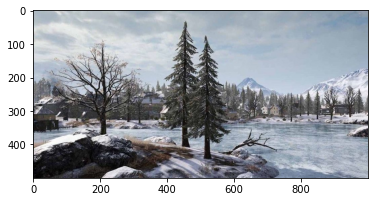

Size of figure:  500 * 1000


In [2]:
img = cv2.imread('images/view6.jpg')
img = img[:,:,::-1]

#normalize the RGB code
img = img/255

#show image
plt.imshow(img)
plt.show()

#size
x, y, z = img.shape
n = x*y
print('Size of figure: ', x,'*',y)

### Define functions

In [3]:
#image partition

def ip(datav):
    rand=calsam()          #randomly picked samples
    K=mk(rand)             #affinity matrix
    D, Dsmall=md(K)
    Q=mq(K, Dsmall, D)
    L, eigvec=eign(Q, D)   #eigenvalues and eigenvectors of diffusion matrix
    Y=my(L, eigvec)        #diffusion map
    print('Diffusiom map done.')
    
    labels=callabel(Y)     #using K-means to cluster data in the diffusion space
    print('Image partition done.')
    
    return labels

In [4]:
def calsam():
    return sort(permutation(n)[:sam])

In [5]:
def mk(rand):
    #distance matrix
    dist=vstack([cdist(datav[rand,:],datav[rand,:]), cdist(delete(datav,rand,axis=0),datav[rand,:])])
    
    #local scaling
    dist_sort=sort(dist, axis=0)    
    sigma=dist_sort[s+1,:]
    sigma[argwhere(sigma==0)]=10000
    sigmasmall=diag(1/sigma)
    
    dist_sort=sort(dist, axis=1)
    sigma=hstack([sigma,dist_sort[sam:,s+1]])
    sigma[argwhere(sigma==0)]=10000
    sigma=sparse.dia_matrix((1/sigma,0), shape=(n,n))
    
    return exp( -sigma.dot(dist).dot(sigmasmall) )    #Affinity matrix

In [6]:
def md(K):
    Dsmall=diag(1/sqrt(sum(K[:sam,:sam],axis=1)))
    D=sparse.dia_matrix((1/sqrt(sum(K,axis=1)),0), shape=(n,n))
    
    return D, Dsmall

In [7]:
def mq(K, Dsmall, D):
    return D.dot(K).dot(Dsmall)

In [8]:
def eign(Q, D):
    A=Q[:sam,:]
    B=Q[sam:,:]
    
    #A^(-1/2)
    uu, ul, uv=svd(A)
    ul=diag(ul**(-0.5))
    Asi=uu.dot(ul).dot(uv)
    
    S=A+Asi.dot(B.transpose()).dot(B).dot(Asi)

    U, L, V=svds(S, dim)

    L=diag(sqrt(L[::-1]))
    U=U[:,::-1]
    
    V=vstack([A,B]).dot(Asi).dot(U).dot(sqrt(inv(L)))
    
    eigvec=D.dot(V)
    
    return L, eigvec

In [9]:
def my(L, eigvec):
    return eigvec.dot(L)

In [10]:
def callabel(Y):
    kmeans=KMeans(clusters)
    kmeans=kmeans.fit(Y)
    labels=array(kmeans.predict(Y)).reshape(n,1)
    
    return labels

### Set parameters

In [11]:
sam=20        #number of sample to comute
s=7           #local scaling parameter
dim=3         #embedding dimension
clusters=20   #reduce image into how many colors

### Calculate the diffusion map and labeling

In [12]:
datav=img.reshape(n, z)
labels=ip(datav)

Diffusiom map done.
Image partition done.


### Display result

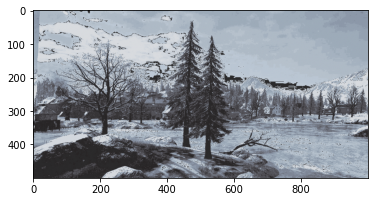

In [13]:
#calculate colors
colorrgb=[]
for i,j in product(range(clusters), range(z)):
    colorrgb.append(percentile( datav[argwhere(labels==i)[:,0],j],50 ))
    
    
#show image
imc=zeros((n,z))
for i in range(clusters): imc[argwhere(labels==i)]=colorrgb[3*i:3*i+3]
imc = imc.reshape(x,y,z)

plt.imshow(imc)
plt.show()

#matplotlib.image.imsave('results/IP_DM_Nystrom_v2/view6_20sam15color.jpg', imc)